This notebook documents my initial attempts to use xgboost and tune the parameters. I assume that the optimisation problem is embarassingly parallel so I can tune each parameter one at a time and save on computational power.

In [8]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [9]:
train = pd.read_csv('Data/train.csv')

In [10]:
fraud = train['isFraud']
X_train = train.drop('isFraud',axis=1)
del train

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, fraud, test_size = 0.75, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.666666, shuffle=False)

In [12]:
#Changing some settings to prevent xgboost from killing the kernal
#see https://stackoverflow.com/questions/51164771/python-xgboost-kernel-died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The first parameter we will tune is the learning rate with default values for all other parameters. We will then proceed sequentially through n_estimators, max_depth, gamma, colsample_bytree and then to early_stopping_rounds. early_stopping_rounds will need to be tuned with an extra test set on top of the validation set.

In [24]:
etas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]

model_results = []

for eta in etas:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = eta,
    objective = 'binary:logistic')
    
    model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set,)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.728976
[1]	validation_0-auc:0.730959
[2]	validation_0-auc:0.730887
[3]	validation_0-auc:0.730932
[4]	validation_0-auc:0.730896
[5]	validation_0-auc:0.730949
[6]	validation_0-auc:0.730943
[7]	validation_0-auc:0.730972
[8]	validation_0-auc:0.762043
[9]	validation_0-auc:0.762028
[10]	validation_0-auc:0.762028
[11]	validation_0-auc:0.762495
[12]	validation_0-auc:0.762513
[13]	validation_0-auc:0.762518
[14]	validation_0-auc:0.762526
[15]	validation_0-auc:0.7658
[16]	validation_0-auc:0.765797
[17]	validation_0-auc:0.765787
[18]	validation_0-auc:0.765806
[19]	validation_0-auc:0.76582
[20]	validation_0-auc:0.765821
[21]	validation_0-auc:0.765893
[22]	validation_0-auc:0.765914
[23]	validation_0-auc:0.765925
[24]	validation_0-auc:0.765911
[25]	validation_0-auc:0.765917
[26]	validation_0-auc:0.775509
[27]	validation_0-auc:0.775613
[28]	validation_0-auc:0.775878
[29]	validation_0-auc:0.77938
[30]	validation_0-auc:0.780097
[31]	validation_0-auc:0.780214
[32]	validation_0-auc:

[67]	validation_0-auc:0.842533
[68]	validation_0-auc:0.842841
[69]	validation_0-auc:0.843416
[70]	validation_0-auc:0.8431
[71]	validation_0-auc:0.843552
[72]	validation_0-auc:0.843639
[73]	validation_0-auc:0.844238
[74]	validation_0-auc:0.844974
[75]	validation_0-auc:0.844708
[76]	validation_0-auc:0.845029
[77]	validation_0-auc:0.845541
[78]	validation_0-auc:0.846009
[79]	validation_0-auc:0.846072
[80]	validation_0-auc:0.845996
[81]	validation_0-auc:0.846916
[82]	validation_0-auc:0.846974
[83]	validation_0-auc:0.847598
[84]	validation_0-auc:0.848069
[85]	validation_0-auc:0.848211
[86]	validation_0-auc:0.848519
[87]	validation_0-auc:0.849405
[88]	validation_0-auc:0.850595
[89]	validation_0-auc:0.851439
[90]	validation_0-auc:0.851889
[91]	validation_0-auc:0.851963
[92]	validation_0-auc:0.852475
[93]	validation_0-auc:0.852702
[94]	validation_0-auc:0.853265
[95]	validation_0-auc:0.853219
[96]	validation_0-auc:0.853228
[97]	validation_0-auc:0.854244
[98]	validation_0-auc:0.854384
[99]	valid

[34]	validation_0-auc:0.858505
[35]	validation_0-auc:0.859076
[36]	validation_0-auc:0.859705
[37]	validation_0-auc:0.860203
[38]	validation_0-auc:0.860035
[39]	validation_0-auc:0.85999
[40]	validation_0-auc:0.859847
[41]	validation_0-auc:0.859702
[42]	validation_0-auc:0.860239
[43]	validation_0-auc:0.86025
[44]	validation_0-auc:0.860141
[45]	validation_0-auc:0.859673
[46]	validation_0-auc:0.860086
[47]	validation_0-auc:0.8601
[48]	validation_0-auc:0.86205
[49]	validation_0-auc:0.861646
[50]	validation_0-auc:0.862029
[51]	validation_0-auc:0.862513
[52]	validation_0-auc:0.862692
[53]	validation_0-auc:0.862883
[54]	validation_0-auc:0.862985
[55]	validation_0-auc:0.863604
[56]	validation_0-auc:0.863988
[57]	validation_0-auc:0.864007
[58]	validation_0-auc:0.86405
[59]	validation_0-auc:0.86483
[60]	validation_0-auc:0.864192
[61]	validation_0-auc:0.865537
[62]	validation_0-auc:0.86604
[63]	validation_0-auc:0.866375
[64]	validation_0-auc:0.865638
[65]	validation_0-auc:0.865728
[66]	validation_

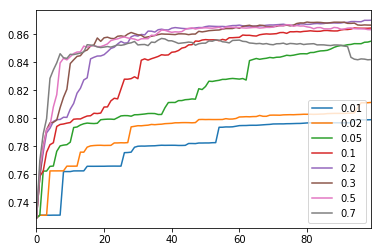

In [30]:
results_eta = [result['validation_0']['auc'] for result in model_results]
results_eta = pd.DataFrame(results_eta).transpose()
results_eta.columns = etas
results_eta.plot.line()

In [ ]:
print(score)

In [ ]:
model.evals_result()['validation_0']['auc'][-1]

In [ ]:
model = xgb.XGBClassifier(
    max_depth = 300,
    learning_rate = 0.1,
    n_estimators = 100,
    objective = 'binary:logistic'
       
)

rounds = np.arange(1,7)
test_scores = []
for round in rounds:
    model.fit(X_train.iloc[:train_rows,:], y_train.iloc[:train_rows], 
          eval_metric = "auc", 
          eval_set= eval_set,
          early_stopping_rounds = round
         )
    last_val_score = model.evals_result()['validation_0']['auc'][-1]
    
    preds = model.predict_proba(X_test)
    test_score = roc_auc_score(y_test, preds[:,1])
    print(test_score)
    
    scores = [last_val_score, test_score]
    test_scores.append(scores)

In [ ]:
print(test_scores)